## Explore the data 

### Load the data into pandas dataframes

In [32]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

train_df = pd.read_csv('data/train.csv', header=0)
test_df = pd.read_csv('data/test.csv', header=0)

### Take a peak

In [2]:
train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


# Preprocessing

#### see : http://scikit-learn.org/stable/modules/preprocessing.html

### Find colums with missing/null/na values

In [3]:
null_col_counts = []

# stack train and test sets
all_X = train_df[test_df.columns].append(test_df[test_df.columns])

# use pandas isnull() to detect null/nan
null_col_counts = [(col, all_X[pd.isnull(all_X[col])].shape[0]) for col in all_X.columns]

null_col_counts

[('PassengerId', 0),
 ('Pclass', 0),
 ('Name', 0),
 ('Sex', 0),
 ('Age', 263),
 ('SibSp', 0),
 ('Parch', 0),
 ('Ticket', 0),
 ('Fare', 1),
 ('Cabin', 1014),
 ('Embarked', 2)]

## Imputation

In [4]:
from sklearn.preprocessing import Imputer

UNKNOWN_VALUE = "NA"

all_X_imputed = all_X.copy()

# Median imputer for numerics

median_imputer = Imputer(missing_values='NaN', 
                         strategy='median', 
                         axis=0)
median_imputer.fit(all_X_imputed[['Fare', 'Age']])
all_X_imputed[['Fare', 'Age']] = median_imputer.transform(all_X_imputed[['Fare', 'Age']])


# Most frequent for categoricals

# scikit_learn has a 'most_frequent' strategy for imputation however it requires 
# your categoricals to be numeric, so we'll borrow from sklearn_pandas
from sklearn_pandas import CategoricalImputer

all_X_imputed[['Embarked']] = CategoricalImputer().fit_transform(all_X_imputed[['Embarked']].as_matrix())

# simply hardcode Cabin to UNKNOWN_VALUE constant
all_X_imputed[['Cabin']] = all_X_imputed[['Cabin']].fillna(UNKNOWN_VALUE, axis=1)

# Now all columns have at least some value
[(col, all_X_imputed[pd.isnull(all_X_imputed[col])].shape[0]) for col in all_X.columns]    

[('PassengerId', 0),
 ('Pclass', 0),
 ('Name', 0),
 ('Sex', 0),
 ('Age', 0),
 ('SibSp', 0),
 ('Parch', 0),
 ('Ticket', 0),
 ('Fare', 0),
 ('Cabin', 0),
 ('Embarked', 0)]

## Encoding

### One-hot-encoding of categoricals using get_dummies from pandas

In [27]:
all_X_encoded = all_X_imputed.copy()

categorical_cols = ['Pclass', 'Embarked', 'Sex']

# I chose to use pandas get_dummies for one hot encoding
for categorical_col in categorical_cols:
    all_X_encoded = pd.concat([pd.get_dummies(all_X_encoded[categorical_col], 
                                              prefix=categorical_col, 
                                              drop_first=True), # no need to keep redundant values
                               all_X_encoded], axis=1)

# drop original categoricals
all_X_encoded.drop(categorical_cols, inplace=True, axis=1)

all_X_encoded.head(5)

,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin
0,1,0,1,0,1,1,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NA
1,0,0,0,0,0,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85
2,0,0,1,0,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NA
3,0,0,1,0,0,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123
4,1,0,1,0,1,5,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NA


### Separate train and test data for further use and pick features we want to use

In [6]:
# cabin and ticket are currently not usable as features
# id is not meaningful
# name requires some work, we'll skip for now
FEATURES_TO_KEEP = ['Sex_male', 'Embarked_Q', 'Embarked_S', 'Pclass_2', 
                    'Pclass_3', 'SibSp', 'Parch', 'Fare', 'Age']

train_X = all_X_encoded[0:train_df.shape[0]][FEATURES_TO_KEEP]
train_Y = train_df['Survived']

test_X = all_X_encoded[0:test_df.shape[0]][FEATURES_TO_KEEP]

## Scaling

### Important for distance-based algorithms (KNN for classification, K-Means for clustering) 
### as well as neural nets and certain classifier objective functions

In [7]:
# mean age is 29.503186
# std : 12.90031

# The scale() function standardizes a column, 
# ie. subtracts mean and divides by standard deviation

from sklearn.preprocessing import scale

scale(train_X[['Age']])[0:10]

array([[-0.56573646],
       [ 0.66386103],
       [-0.25833709],
       [ 0.4333115 ],
       [ 0.4333115 ],
       [-0.1046374 ],
       [ 1.89345853],
       [-2.10273333],
       [-0.18148724],
       [-1.18053521]])

### Standard Scaler does the same but gives you a 'fit' object to apply to the test and validation sets 
### separately which is a good practice (https://sebastianraschka.com/faq/docs/scale-training-test.html)
### (keeps the test dataset 'pure' treating it as 'new, unseen data')

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(train_X)

test_X_scaled = scaler.transform(test_X)

# note that we now have a matrix (2-dim numpy array), not a dataframe

test_X_scaled[0:5]

array([[ 0.73769513, -0.30756234,  0.61583843, -0.51015154,  0.90258736,
         0.43279337, -0.47367361, -0.50244517, -0.56573646],
       [-1.35557354, -0.30756234, -1.62380254, -0.51015154, -1.10792599,
         0.43279337, -0.47367361,  0.78684529,  0.66386103],
       [-1.35557354, -0.30756234,  0.61583843, -0.51015154,  0.90258736,
        -0.4745452 , -0.47367361, -0.48885426, -0.25833709],
       [-1.35557354, -0.30756234,  0.61583843, -0.51015154, -1.10792599,
         0.43279337, -0.47367361,  0.42073024,  0.4333115 ],
       [ 0.73769513, -0.30756234,  0.61583843, -0.51015154,  0.90258736,
        -0.4745452 , -0.47367361, -0.48633742,  0.4333115 ]])

### Can go back to original values

In [9]:
scaler.inverse_transform(test_X_scaled)[0:5]

array([[ 1.    ,  0.    ,  1.    ,  0.    ,  1.    ,  1.    ,  0.    ,
         7.25  , 22.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  1.    ,  0.    ,
        71.2833, 38.    ],
       [ 0.    ,  0.    ,  1.    ,  0.    ,  1.    ,  0.    ,  0.    ,
         7.925 , 26.    ],
       [ 0.    ,  0.    ,  1.    ,  0.    ,  0.    ,  1.    ,  0.    ,
        53.1   , 35.    ],
       [ 1.    ,  0.    ,  1.    ,  0.    ,  1.    ,  0.    ,  0.    ,
         8.05  , 35.    ]])

### MinMaxScaler scales to a particular range. 
#### Beware outliers! (see : http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)

In [10]:
# if we want all features to be on the same scale we want to use MinMax
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(train_X)

# Scales to 0 : 1 range by default
test_X_scaled = scaler.transform(test_X)

test_X_scaled[0:5]

array([[1.        , 0.        , 1.        , 0.        , 1.        ,
        0.125     , 0.        , 0.01415106, 0.27117366],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.125     , 0.        , 0.13913574, 0.4722292 ],
       [0.        , 0.        , 1.        , 0.        , 1.        ,
        0.        , 0.        , 0.01546857, 0.32143755],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.125     , 0.        , 0.1036443 , 0.43453129],
       [1.        , 0.        , 1.        , 0.        , 1.        ,
        0.        , 0.        , 0.01571255, 0.43453129]])

### Common to scale to -1 : 1 range

In [11]:
scaler = MinMaxScaler(feature_range=(-1, 1)).fit(train_X)

scaler.transform(train_X)[0:5]

array([[ 1.        , -1.        ,  1.        , -1.        ,  1.        ,
        -0.75      , -1.        , -0.97169788, -0.45765268],
       [-1.        , -1.        , -1.        , -1.        , -1.        ,
        -0.75      , -1.        , -0.72172853, -0.05554159],
       [-1.        , -1.        ,  1.        , -1.        ,  1.        ,
        -1.        , -1.        , -0.96906286, -0.35712491],
       [-1.        , -1.        ,  1.        , -1.        , -1.        ,
        -0.75      , -1.        , -0.79271141, -0.13093742],
       [ 1.        , -1.        ,  1.        , -1.        ,  1.        ,
        -1.        , -1.        , -0.96857489, -0.13093742]])

## Classification

#### see : http://scikit-learn.org/stable/supervised_learning.html#supervised-learning

### Linear Classifiers
#### see : http://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model

### Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()
model_lr = logistic.fit(train_X, train_Y)
model_lr.predict(test_X)

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,

### With a bit of tuning

In [13]:
model_lr = LogisticRegression(penalty='l2', 
                              tol=0.0001, 
                              C=1.0, 
                              fit_intercept=True, 
                              solver='liblinear').fit(train_X, train_Y)

model_lr.predict(test_X)[0:20]

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1])

### Can get predictions as probability

In [14]:
model_lr.predict_proba(test_X)[0:10]

array([[0.90567167, 0.09432833],
       [0.11302745, 0.88697255],
       [0.39995215, 0.60004785],
       [0.14984704, 0.85015296],
       [0.91248629, 0.08751371],
       [0.8560105 , 0.1439895 ],
       [0.73494987, 0.26505013],
       [0.90708585, 0.09291415],
       [0.44324643, 0.55675357],
       [0.11686569, 0.88313431]])

### Tree Based classifiers

In [28]:
from sklearn.tree import DecisionTreeClassifier

model_dt = DecisionTreeClassifier().fit(train_X, train_Y)

model_dt.predict(train_X)[0:20]

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1])

## Ensembles

#### see : http://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble

#### Boosting with Adaboost

In [16]:
from sklearn.ensemble import AdaBoostClassifier

model_adaboost = AdaBoostClassifier(n_estimators=100).fit(train_X, train_Y)
model_adaboost.predict(test_X)[0:20]

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1])

#### Bagging with Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier().fit(train_X, train_Y)
model_rf.predict(test_X)[0:20]

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1])

#### Gradient Boosting with XGBoost

In [20]:
# Separate library but interoperable with scikit modules
import xgboost as xgb

model_xgb = xgb.XGBClassifier().fit(train_X, train_Y)
model_xgb.predict(test_X)[0:20]

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1])

## Getting the most out of your classifier
#### see : http://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection

#### Simple K-fold cross validation 

In [21]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model_xgb, 
                            train_X, 
                            train_Y, 
                            cv=5)

print("Scores : {0}".format(cv_scores))
print("Avg score : {0}".format(cv_scores.mean()))
print("Confidence interval : {0} - {1}".format(cv_scores.mean() - cv_scores.std() * 2, 
                                               cv_scores.mean() + cv_scores.std() * 2))

Scores : [0.81564246 0.82122905 0.84269663 0.80337079 0.84745763]
Avg score : 0.826079310245774
Confidence interval : 0.7928371962771164 - 0.8593214242144316


#### Using another metric, recall for instance

In [22]:
cv_scores = cross_val_score(model_xgb, 
                            train_X, 
                            train_Y, 
                            cv=5, 
                            scoring='recall') # typically accuracy by default

print("Avg recall : {0}".format(cv_scores.mean()))

Avg recall : 0.6929667519181586


In [23]:
# Using another splitting/shuffling strategy (StratifiedKFold is used by default)
# Data is shuffled with each split, could be overlap among folds

from sklearn.model_selection import StratifiedShuffleSplit

cv_scores = cross_val_score(model_xgb, 
                            train_X, 
                            train_Y, 
                            cv = StratifiedShuffleSplit())

print("Avg score : {0}".format(cv_scores.mean()))

Avg score : 0.8355555555555554


In [24]:
# Grid Search cross validation using GridSearchCV with AUC as key metric

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score

parameters = {
 'learning_rate': [.01, 0.1, .2], 
 'max_depth': [2, 4, 6],
 'n_estimators': [50, 100, 200],
 'reg_alpha':[0.01, .1, .5],
 'reg_lambda':[0.01, .1, .5]
}

# Exhaustive search over all param combos
# Can run in parallel using 'n_jobs' arg
# Can specify key metric using 'scoring' arg
grid_obj = GridSearchCV(xgb.XGBClassifier(), 
                        parameters, 
                        scoring=make_scorer(roc_auc_score), # tune to whichever metric you like
                        cv=5, # number of folds
                        verbose=1, 
                        n_jobs=4) # parallelize the work

# Model of type GridSearchCV, contains cv related data as well as the model itself
model_gridsearchcv = grid_obj.fit(train_X, train_Y)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[Parallel(n_jobs=4)]: Done 538 tasks      | elapsed:    7.1s
[Parallel(n_jobs=4)]: Done 1208 out of 1215 | elapsed:   18.3s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 1215 out of 1215 | elapsed:   18.7s finished


### Gives you the best estimator (classifier) based on the metric you specify

In [25]:
print("Best param combo : \n{0}".format(model_gridsearchcv.best_estimator_))
print("\nBest score : \n{0}".format(model_gridsearchcv.best_score_))

Best param combo : 
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.5, reg_lambda=0.01, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Best score : 
0.8184956306648308


### Chaining multiple operations using Pipelines

In [26]:
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

estimators = [
    ('standard_scaler', StandardScaler()), 
    ('pca', PCA(n_components=4)),  # Use PCA feature reduction to keep top 4 components of 9 features
    ('knn', KNeighborsClassifier())
]

pipeline = Pipeline(estimators)

pipeline.fit(train_X, train_Y) # run fit on all 3 estimators

pipeline.predict(test_X)[0:20] # run predict on final estimator

array([0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0])

## Data generation
#### see : http://scikit-learn.org/stable/datasets/index.html

### Many standard datasets available for experimentation

#### Some are useful for regression

In [35]:
from sklearn.datasets import load_boston

boston = load_boston()

print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

### Some useful for classification

In [37]:
from sklearn.datasets import load_wine

wine = load_wine()

print(wine.DESCR)

Wine Data Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- 1) Alcohol
 		- 2) Malic acid
 		- 3) Ash
		- 4) Alcalinity of ash  
 		- 5) Magnesium
		- 6) Total phenols
 		- 7) Flavanoids
 		- 8) Nonflavanoid phenols
 		- 9) Proanthocyanins
		- 10)Color intensity
 		- 11)Hue
 		- 12)OD280/OD315 of diluted wines
 		- 13)Proline
        	- class:
                - class_0
                - class_1
                - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash: 

### Can generate your own classification data

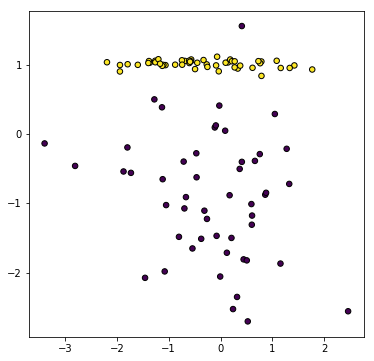

In [38]:
%matplotlib inline

from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

# n_features - number of features, or x values
# n_redundant - allows to generate features which largley duplicate each other
# n_informative - control how many features are 'useful'

# This group is easily separable
X1, LABEL1 = make_classification(n_features=2, 
                                 n_redundant=0, 
                                 n_informative=1,
                                 n_clusters_per_class=1)

plt.figure(figsize=(6, 6))
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=LABEL1, s=30, edgecolor='k')

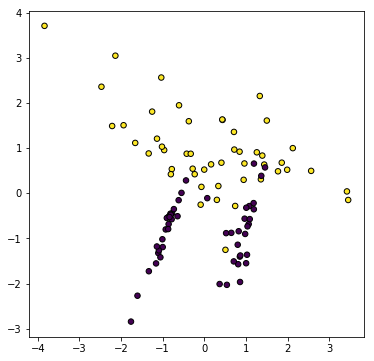

In [39]:
# both informative, 2 clusters within the labels/classes

X2, LABEL2 = make_classification(n_features=2, 
                             n_redundant=0, 
                             n_informative=2,
                             n_clusters_per_class=2) # makes data tougher to separate

# This group, not so separable...
plt.figure(figsize=(6, 6))
plt.scatter(X2[:, 0], X2[:, 1], marker='o', c=LABEL2, s=30, edgecolor='k')

## Clustering
#### see : http://scikit-learn.org/stable/modules/clustering.html#clustering

### KMeans first dataset, 2 clusters

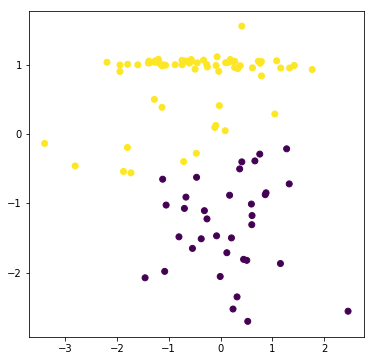

In [40]:
from sklearn.cluster import KMeans

# fit_predict() allows to do simple clustering in a single line

y_pred = KMeans(n_clusters=2, random_state=17).fit_predict(X1)

plt.figure(figsize=(6, 6))
plt.scatter(X1[:, 0], X1[:, 1], c=y_pred)

### KMeans first dataset, 5 clusters

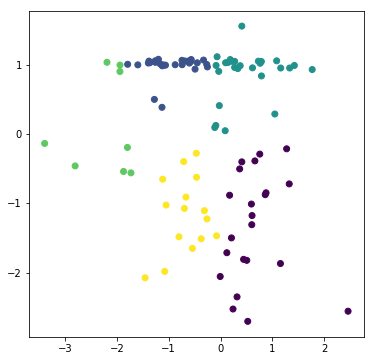

In [41]:
y_pred = KMeans(n_clusters=5, random_state=17).fit_predict(X1)

plt.figure(figsize=(6, 6))
plt.scatter(X1[:, 0], X1[:, 1], c=y_pred)

### DBSCAN, first dataset

#### DBSCAN gives a -1 label for records which are considered not to belong to a cluster (seen by the darker purple points)

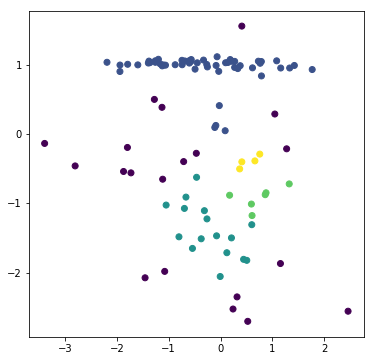

In [42]:
from sklearn.cluster import DBSCAN

# Doesn't take a cluster count, decides on it's own how many clusters it sees

# Able to label items as not belonging to a cluster (-1 label), 
# so useful as a outlier detector

y_pred = DBSCAN().fit_predict(X1)

plt.figure(figsize=(6, 6))
plt.scatter(X1[:, 0], X1[:, 1], c=y_pred)

## Feature selection
#### see : http://scikit-learn.org/stable/modules/feature_selection.html

### Filter features with low variance

In [43]:
from sklearn.feature_selection import VarianceThreshold

print("Columns before variance thresholding : {0}".format(train_X.shape[1]))

train_X_var_thresh = VarianceThreshold(threshold=.2).fit_transform(train_X)
print("Columns after variance thresholding : {0}".format(train_X_var_thresh.shape[1]))

Columns before variance thresholding : 9
Columns after variance thresholding : 6


### Recursive Feature Elimination

In [29]:
from sklearn.feature_selection import RFE

# Feature reduction within context of a classifier
# Trains on all features and uses "coef_" or "feature_importances_" of the classifier
# to recursively prune features

selector = RFE(LogisticRegression(), 
               n_features_to_select=5)

model = selector.fit(train_X, train_Y)

#### Use the RFE.support_ attribute to see which features were deemed significant/important

In [30]:
train_X.columns[model.support_]

Index(['Sex_male', 'Embarked_S', 'Pclass_2', 'Pclass_3', 'SibSp'], dtype='object')

#### Use RFE.ranking_ to see the importance rank of each feature

In [31]:
list(zip(train_X.columns, selector.ranking_))

[('Sex_male', 1),
 ('Embarked_Q', 4),
 ('Embarked_S', 1),
 ('Pclass_2', 1),
 ('Pclass_3', 1),
 ('SibSp', 1),
 ('Parch', 3),
 ('Fare', 5),
 ('Age', 2)]